![Python Logo](../../assets/images/python-logo-master-v3-TM.png)

# <center> Applying Word2Vec on AskUbuntu Question Data </center>
### <center> Shagun Sodhani </center>

In [1]:
# put in the name of the Stack Exchange Site which you want to analyse.
data_source = "AskUbuntu"
data_type = "Question"

## Let us begin

### We will import everything in one cell for the sake for reference.

In [2]:
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.feature import Word2VecModel
from pyspark.ml.feature import PCA
from time import time
import operator
%matplotlib inline
from __future__ import print_function

### Now let us load the question data as a dataframe. Since we will be using this data many times, we will cache it in memory.

In [3]:
start_time = time()
print ("data_source =", data_source)
print ("data_type =", data_type)
question_data_path = "../data/"+data_source+"/"+data_type
print ("question_data_path =",question_data_path)
question_df = sqlContext.read.load(question_data_path).cache()
print ("Time taken =", time() - start_time, "seconds.")

data_source = AskUbuntu
data_type = Question
question_data_path = ../data/AskUbuntu/Question
Time taken = 17.8108348846 seconds.


In [4]:
print("Schema for question dataframe")
question_df.printSchema()

Schema for question dataframe
root
 |-- Id: long (nullable = true)
 |-- AcceptedAnswerId: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Score: long (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- LastEditorUserId: long (nullable = true)
 |-- LastEditorDisplayName: string (nullable = true)
 |-- LastEditDate: string (nullable = true)
 |-- LastActivityDate: string (nullable = true)
 |-- CommunityOwnedDate: string (nullable = true)
 |-- ClosedDate: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- FavoriteCount: long (nullable = true)



### We want to play with the question text data.

In [5]:
question_df.select('Body').show(10)

+--------------------+
|                Body|
+--------------------+
|<p>Every time I t...|
|<p>How can I set ...|
|<p>What are some ...|
|<p>I have a ubunt...|
|<p>I'm taking my ...|
|<p>I started with...|
|<p>Update Manager...|
|<p>I have had sig...|
|<p>I'd like to ha...|
|<p>I've followed ...|
+--------------------+
only showing top 10 rows



In [6]:
question_df.select('Body').head()[0]

u'<p>Every time I turn on my computer, I see a message saying something like:</p>\n\n<pre><code>Your battery may be old or broken.\n</code></pre>\n\n<p>I am already aware that my battery is bad. How do I suppress this message?</p>\n'

### We need to clean up this data. Specifically, we want to remove the all the html tags and everything between the 'code' tags. We will use the [regex_replace](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_replace) function.

In [7]:
regex_to_remove = '<[^>]*>'
body_df = question_df.select(func.regexp_replace\
                   (func.regexp_replace('Body', '\n', ' '), regex_to_remove, '').alias('Body'))
body_df.head()[0]

u'Every time I turn on my computer, I see a message saying something like:  Your battery may be old or broken.   I am already aware that my battery is bad. How do I suppress this message? '

### Now we will replace each row with an array of words before we feed it to the Word2Vec Model. For this, we would use the [split function](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.functions.split) 

In [8]:
body_df.select(func.split('Body', ' ').alias('Body')).head()[0]

[u'Every',
 u'time',
 u'I',
 u'turn',
 u'on',
 u'my',
 u'computer,',
 u'I',
 u'see',
 u'a',
 u'message',
 u'saying',
 u'something',
 u'like:',
 u'',
 u'Your',
 u'battery',
 u'may',
 u'be',
 u'old',
 u'or',
 u'broken.',
 u'',
 u'',
 u'I',
 u'am',
 u'already',
 u'aware',
 u'that',
 u'my',
 u'battery',
 u'is',
 u'bad.',
 u'How',
 u'do',
 u'I',
 u'suppress',
 u'this',
 u'message?',
 u'']

### We have many empty words, words in different cases and unnecessary punctuation marks in data. Lets update the regex to take care of these issues.


In [9]:
regex_to_remove = '<[^>]*>|\\\'|"|\(|\)|\[|\]'
body_df = question_df.select(func.lower(func.regexp_replace\
                   (func.regexp_replace('Body', '\n', ' '), regex_to_remove, '')).alias('Body'))
body_df = body_df.select(func.split('Body', ' ').alias('Body'))
print ("Number of words =", len(body_df.head()[0]))
body_df.head()[0]

Number of words = 40


[u'every',
 u'time',
 u'i',
 u'turn',
 u'on',
 u'my',
 u'computer,',
 u'i',
 u'see',
 u'a',
 u'message',
 u'saying',
 u'something',
 u'like:',
 u'',
 u'your',
 u'battery',
 u'may',
 u'be',
 u'old',
 u'or',
 u'broken.',
 u'',
 u'',
 u'i',
 u'am',
 u'already',
 u'aware',
 u'that',
 u'my',
 u'battery',
 u'is',
 u'bad.',
 u'how',
 u'do',
 u'i',
 u'suppress',
 u'this',
 u'message?',
 u'']

### We will remove the empty words using a udf (user defined function)

In [10]:
from pyspark.sql.types import ArrayType, StringType
remove_empty = func.udf(lambda row: filter(None, row), ArrayType(StringType()))
body_df = body_df.select(remove_empty('Body').alias('Body'))
print ("Number of words =", len(body_df.head()[0]))
body_df.head()[0]

Number of words = 36


[u'every',
 u'time',
 u'i',
 u'turn',
 u'on',
 u'my',
 u'computer,',
 u'i',
 u'see',
 u'a',
 u'message',
 u'saying',
 u'something',
 u'like:',
 u'your',
 u'battery',
 u'may',
 u'be',
 u'old',
 u'or',
 u'broken.',
 u'i',
 u'am',
 u'already',
 u'aware',
 u'that',
 u'my',
 u'battery',
 u'is',
 u'bad.',
 u'how',
 u'do',
 u'i',
 u'suppress',
 u'this',
 u'message?']

### Now that our data has been preprocessed, we can setup our model.


In [11]:
start_time = time()
word2vec = Word2Vec().setSeed(42)
body_data = body_df.map(lambda row: row[0])
model = word2vec.fit(body_data)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 643.938068151 seconds.


### We would save our model on disk so that we do not have to train it again.


In [14]:
path_to_save_model = "model/AskUbuntu/Question/Word2Vec"

In [15]:
start_time = time()
model.save(sc, path_to_save_model)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 6.62208914757 seconds.


### Now we see how to load the model from disk to main memory.


In [16]:
start_time = time()
loaded_model = Word2VecModel.load(sc, path_to_save_model)
word_to_test = "ubuntu"
loaded_model.transform(word_to_test) == model.transform(word_to_test)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 8.93023395538 seconds.


### Lets play with it now.


In [17]:
model.findSynonyms("14.04", 5)
word = "14.04"
synonyms = model.findSynonyms(word, 5)

for word, similarity in synonyms:
    print("{}: {}".format(word, similarity))
print (model)

12.04: 2.14995840008
14.10: 2.08453867697
14.04.02: 2.07786779307
13.04: 2.06817863143
11.10: 2.05944842234


In [18]:
word = "bash"
synonyms = model.findSynonyms(word, 5)

for word, similarity in synonyms:
    print("{}: {}".format(word, similarity))

script,: 1.56483266616
script.: 1.51523162365
test.sh: 1.47905688244
sh: 1.47288772097
script: 1.46407333431


In [19]:
word = "trusty"
synonyms = model.findSynonyms(word, 5)

for word, similarity in synonyms:
    print("{}: {}".format(word, similarity))

precise: 3.16329848679
utopic: 3.1009635714
saucy: 2.99641159832
raring: 2.93836895775
quantal: 2.88408357544


In [20]:
word1 = "14.04"
word2 = "trusty"
word3 = "12.04"
word4 = model.findSynonyms(model.transform(word1) + model.transform(word2) - model.transform(word3), 1)[0][0]
print (word4)

precise


### 14.04 + trusty - 12.04 = precise

### We will now visualise all the tags using Word2Vec

### We will first get a list of all the tags

In [21]:
tags_df = question_df.select(func.regexp_replace\
                   (func.regexp_replace('Tags', '><', ','), '<|>', '').alias('Tags'))
tags_df.show(10, truncate = False)

+-----------------------------------------------+
|Tags                                           |
+-----------------------------------------------+
|power-management,notification                  |
|software-center,software-installation,policykit|
|upgrade,live-cd,system-installation            |
|server,ssh,security,remote-desktop,vnc         |
|community,locoteams                            |
|kde,login-screen,plymouth                      |
|updates,unattended-upgrades                    |
|flash,software-installation                    |
|updates                                        |
|10.04,mouse,xrandr,displaylink                 |
+-----------------------------------------------+
only showing top 10 rows



In [22]:
tag_df = tags_df.select(func.explode(func.split('Tags', ',')).alias('Tag'))
tag_df.show(10, truncate = False)

+---------------------+
|Tag                  |
+---------------------+
|power-management     |
|notification         |
|software-center      |
|software-installation|
|policykit            |
|upgrade              |
|live-cd              |
|system-installation  |
|server               |
|ssh                  |
+---------------------+
only showing top 10 rows



In [23]:
tag_df = tag_df.distinct()
print ("Number of distinct tags =", tag_df.count())

Number of distinct tags = 2974


### Now we will map the tags with their word2Vec vectors using the trained model.

### We will use a small utility function to filter tags that are not seen by our model (to be on the safe side).

In [24]:
def tag_in_model(tag):
    try:
        model.transform(tag)
        return True
    except Exception as e:
        return False

In [25]:
tag_list = tag_df.distinct().map(lambda tag: tag[0]).collect()
tag_vector_list = filter(tag_in_model, tag_list)
print ("Total number of tags =",len(tag_list))
print ("Number of tags after filtering =",len(tag_vector_list))

Total number of tags = 2974
Number of tags after filtering = 2367


In [26]:
tag_vector_map = [(tag, model.transform(tag)) for tag in tag_vector_list]
tag_vector_map[0]

(u'launchpad',
 DenseVector([0.1513, 0.2757, 0.2896, 0.2815, 0.2618, 0.2554, -0.1214, 0.031, -0.1211, 0.1255, -0.0349, 0.0162, -0.2299, -0.1769, -0.0507, -0.0811, -0.0034, -0.247, 0.3558, -0.0767, -0.7111, 0.1297, -0.1677, 0.2353, 0.2162, 0.3739, -0.1142, 0.1805, 0.4073, -0.1968, 0.0397, -0.1609, 0.0827, -0.1248, -0.2248, -0.1019, 0.0627, 0.1044, 0.0702, 0.1083, -0.1442, -0.2428, 0.148, -0.0647, -0.0123, -0.0793, 0.0139, -0.0418, -0.3017, -0.1848, 0.0497, -0.1624, 0.0168, 0.242, -0.0007, -0.2104, -0.2498, -0.0346, -0.4378, 0.0506, 0.2289, -0.3361, 0.4515, -0.0796, -0.0471, 0.2627, 0.0255, -0.4328, -0.0659, 0.2456, -0.1693, 0.0626, 0.1465, 0.1705, -0.2604, -0.3322, -0.0579, 0.256, -0.2306, 0.19, 0.0148, -0.0524, 0.1804, 0.1665, -0.1396, 0.1975, 0.0702, 0.0549, -0.0435, 0.0186, 0.071, 0.1101, -0.2119, -0.0716, -0.2469, 0.0432, 0.2752, -0.4141, 0.1746, 0.1512]))

### So far, we have been reading RDDs and DataFrames. Now, we will make a RDD and a DataFrame from a list.

In [27]:
tag_vector_rdd = sc.parallelize(tag_vector_map, 9)
tag_vector_rdd.take(1)

[(u'launchpad',
  DenseVector([0.1513, 0.2757, 0.2896, 0.2815, 0.2618, 0.2554, -0.1214, 0.031, -0.1211, 0.1255, -0.0349, 0.0162, -0.2299, -0.1769, -0.0507, -0.0811, -0.0034, -0.247, 0.3558, -0.0767, -0.7111, 0.1297, -0.1677, 0.2353, 0.2162, 0.3739, -0.1142, 0.1805, 0.4073, -0.1968, 0.0397, -0.1609, 0.0827, -0.1248, -0.2248, -0.1019, 0.0627, 0.1044, 0.0702, 0.1083, -0.1442, -0.2428, 0.148, -0.0647, -0.0123, -0.0793, 0.0139, -0.0418, -0.3017, -0.1848, 0.0497, -0.1624, 0.0168, 0.242, -0.0007, -0.2104, -0.2498, -0.0346, -0.4378, 0.0506, 0.2289, -0.3361, 0.4515, -0.0796, -0.0471, 0.2627, 0.0255, -0.4328, -0.0659, 0.2456, -0.1693, 0.0626, 0.1465, 0.1705, -0.2604, -0.3322, -0.0579, 0.256, -0.2306, 0.19, 0.0148, -0.0524, 0.1804, 0.1665, -0.1396, 0.1975, 0.0702, 0.0549, -0.0435, 0.0186, 0.071, 0.1101, -0.2119, -0.0716, -0.2469, 0.0432, 0.2752, -0.4141, 0.1746, 0.1512]))]

In [28]:
tag_vector_df = tag_vector_rdd.toDF(['Tag', 'Vector'])
tag_vector_df.show(2)

+-----------+--------------------+
|        Tag|              Vector|
+-----------+--------------------+
|  launchpad|[0.15134425461292...|
|preferences|[0.19372023642063...|
+-----------+--------------------+
only showing top 2 rows



### Now we will use PCA to reduce the dimensionality of vector to 2

In [29]:
pca = PCA(k=2, inputCol="Vector", outputCol="pca_features")

In [30]:
start_time = time()
pca_model = pca.fit(tag_vector_df)
tag_pca_df = pca_model.transform(tag_vector_df)
tag_pca_df.select('Tag', 'pca_features').show(5, truncate=False)
print ("Time taken =", time() - start_time, "seconds.")

+-----------+-------------------------------------------+
|Tag        |pca_features                               |
+-----------+-------------------------------------------+
|launchpad  |[0.4261175759319572,-0.5623468956455119]   |
|preferences|[0.0017806417105137732,-0.9883550653645172]|
|qt3        |[0.3243122994602847,-0.2774725449026905]   |
|rabbitmq   |[0.2519227045497695,-0.08339481144272831]  |
|photorec   |[0.30582310843073596,-0.4446517559777798]  |
+-----------+-------------------------------------------+
only showing top 5 rows

Time taken = 2.09640407562 seconds.


### Next, we visualise these pca_features using matplotlib

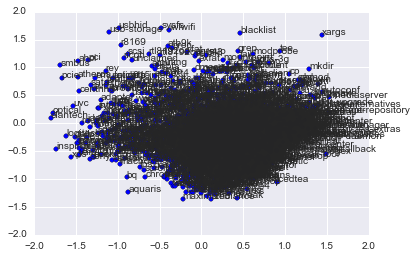

Time taken = 9.67411708832 seconds.


In [31]:
start_time = time()
position_data = tag_pca_df.select('Tag', 'pca_features').map(lambda row: (row[0], row[1][0], row[1][1])).collect()
name_list, xs, ys = zip(*position_data)
# %matplotlib qt
fig, ax = plt.subplots()
ax.scatter(xs, ys, marker = 'o')
for i, txt in enumerate(name_list):
    ax.annotate(txt, (xs[i],ys[i]))
plt.show()
print ("Time taken =", time() - start_time, "seconds.")

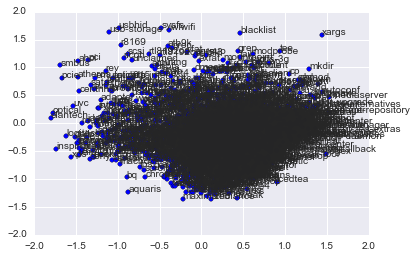

Time taken = 8.33382296562 seconds.


In [32]:
start_time = time()
position_data = tag_pca_df.select('Tag', 'pca_features').map(lambda row: (row[0], row[1][0], row[1][1])).collect()
name_list, xs, ys = zip(*position_data)
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(xs, ys, marker = 'o')
for i, txt in enumerate(name_list):
    ax.annotate(txt, (xs[i],ys[i]))
plt.show()
print ("Time taken =", time() - start_time, "seconds.")